In [68]:
from torch.utils.data import Dataset
# from modules.utils import load_json
import numpy as np
from PIL import Image
import os
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix 
import pandas as pd
import os
import sys
from torch import nn
import timm
from datetime import datetime, timezone, timedelta 
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import logging
import torch
import csv
import torchvision.transforms as transforms
import numpy as np
import torch
import torch.optim as optim
from time import time
from tqdm import tqdm
from torch.nn import functional as F
import torch
import torch.nn as nn
import cv2
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch.optim as optim
from itertools import product
import logging
import random
import pickle
import shutil
import json
import yaml
import csv
import os 
from scipy.stats import entropy

In [67]:
class CowDataset(Dataset):
    def __init__(self, img_folder, dfpath, transform):
        self.df = pd.read_csv(dfpath, usecols=['imname','grade'],dtype={'grade':str})
        self.label_encoding = {'1++':0, '1+':1, '1':2, '2':3, '3':4}
        self.img_folder = img_folder
        self.transforms = transform
        
        self.image_names = self.df['imname']
        self.labels = self.df['grade']
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        impath = os.path.join(self.img_folder, self.image_names[index])
        img = Image.open(impath).convert('RGB')
        img_cv = cv2.imread(impath)
        histr = []
        for chn in [0, 1, 2]:
            histr.append(cv2.calcHist([img_cv],[chn],None,[256],[0,256]))
        histr = np.concatenate(histr, axis=0).squeeze()
        
        img = self.transforms(img)
        target = self.labels[index]
        lbl = self.label_encoding[target]
        
        return img, histr, lbl

class TestDataset(Dataset):
    def __init__(self, img_folder, dfpath):
        self.df = pd.read_csv(dfpath, usecols=['imname'],dtype={'imname':str})
        self.img_folder = img_folder
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456,0.406],[0.229,0.224,0.225])
        ])
        self.image_names = self.df['imname']
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        impath = os.path.join(self.img_folder, self.image_names[index])
        img = Image.open(impath)
        img_cv = cv2.imread(impath)
        histr = []
        for chn in [0, 1, 2]:
            histr.append(cv2.calcHist([img_cv],[chn],None,[256],[0,256]))
        histr = np.concatenate(histr, axis=0).squeeze()
        img = self.transforms(img)
        filename = self.image_names[index]
        
        return img, histr, filename

In [49]:
np.concatenate([histr, histr, histr], axis=0).squeeze().shape

(768,)

In [69]:
class ConfusionRateLoss(nn.Module):
    def __init__(self):
        super(ConfusionRateLoss, self).__init__() 
        self.k = 3
    
    def get_cr_matrix(self, y_true, y_pred):
        y_pred_int = torch.argmax(y_pred)
        c_matrix = confusion_matrix(y_true.cpu().detach().numpy(), y_pred_int.cpu().detach().numpy())
        denom = c_matrix + np.transpose(c_matrix)
        cr_matrix = c_matrix / denom
        for i in range(len(cr_matrix)):
            cr_matrix[i, i] = 0
        return cr_matrix
    
    def forward(self, y_true, y_pred):
        cr_matrix = self.get_cr_matrix(y_true, y_pred)
        ce_loss = F.cross_entropy(y_pred, y_true)
        
        losses = []
        for i in range(len(y_true)):
            y, y_hat = y_true[i].item(), y_pred[i].item()
            if y != y_hat:
                ent = entropy(cr_matrix[y, y_hat], cr_matrix[y_hat, y]) 
                losses.append(ent)
        ent_loss = sum(losses) / len(losses)
        return ce_loss + self.k * ce_loss * ent_loss

In [70]:
class FocalLoss(nn.Module):
    def __init__(self):
        super(FocalLoss, self).__init__()
        
    def forward(self, inputs, targets, alpha, gamma):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        BCE = F.binary_cross_entropy(inputs, targets, reduction='none')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
        
        return focal_loss  

class KappaScore:
    def __init__(self):
        super(KappaScore, self).__init__()

    def quadratic_weighted_kappa(self, c_matrix):
        numer = 0.0
        denom = 0.0

        for i in range(c_matrix.shape[0]):
            for j in range(c_matrix.shape[1]):
                n = c_matrix.shape[0]
                wij = ((i-j)**2.0)/((n-1)**2)
                oij = c_matrix[i,j]
                eij = c_matrix[i,:].sum() * c_matrix[:,j].sum()/c_matrix.sum()
                numer += wij*oij
                denom += wij*eij
        return 1.0 - numer/denom
    
    def get_score(self, y_true, y_pred):
        c_matrix = confusion_matrix(y_true, y_pred)
        kappa = self.quadratic_weighted_kappa(c_matrix)
        return kappa

class F1Score:
    
    def __init__(self, average):
        self.average = average
        
    def get_score(self, y_true, y_pred):
        return f1_score(y_true, y_pred, average=self.average) 

class MultiLoss(nn.Module):
    def __init__(self):
        super(MultiLoss, self).__init__()
        self.kappa_metric = KappaScore()
        self.alpha = 0.5
        
    def forward(self, inputs, targets): 
        ce_loss = F.cross_entropy(inputs, targets)

        inputs = inputs.argmax(dim=1) 
        kappa_score = self.kappa_metric.get_score(inputs.cpu().tolist(), targets.cpu().tolist())
        if kappa_score > 0:
            kp_loss = 1 / self.kappa_metric.get_score(inputs.cpu().tolist(), targets.cpu().tolist())
        else:
            kp_loss = 1
        multi_loss = self.alpha * ce_loss + (1-self.alpha) * kp_loss
        
        return multi_loss

In [71]:
import math
from torch.optim import Optimizer
class _LRScheduler(object):
    def __init__(self, optimizer, last_epoch=-1):
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer
        if last_epoch == -1:
            for group in optimizer.param_groups:
                group.setdefault('initial_lr', group['lr'])
            last_epoch = 0
        else:
            for i, group in enumerate(optimizer.param_groups):
                if 'initial_lr' not in group:
                    raise KeyError("param 'initial_lr' is not specified "
                                   "in param_groups[{}] when resuming an optimizer".format(i))
        self.base_lrs = list(map(lambda group: group['initial_lr'], optimizer.param_groups))
        self.step(last_epoch)

    def state_dict(self):
        """Returns the state of the scheduler as a :class:`dict`.
        It contains an entry for every variable in self.__dict__ which
        is not the optimizer.
        """
        return {key: value for key, value in self.__dict__.items() if key != 'optimizer'}

    def load_state_dict(self, state_dict):
        """Loads the schedulers state.
        Arguments:
            state_dict (dict): scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        self.__dict__.update(state_dict)

    def get_lr(self):
        raise NotImplementedError

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
        self.T_cur = last_epoch
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [72]:
def cut(W,H,lam):
        
    ######define the size of box######
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int64(W * cut_rat)
    cut_h = np.int64(H * cut_rat) 
    ######define the size of box######
    
    #####randomly choose where to cut#####
    cx = np.random.randint(W) # uniform distribution
    cy = np.random.randint(H)
    #####randomly choose where to cut#####

    bbx1 = np.clip(cx - cut_w // 2, 0, W) # Cut, return coordinates of the box 
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [73]:
class Trainer():
    
    def __init__(self, model, loss, optimizer, device):
        self.model = model 
        self.optimizer = optimizer
#         self.scheduler = CosineAnnealingWarmUpRestarts(self.optimizer, T_0=50, T_mult=1, eta_max=0.1, T_up=10, gamma=0.5)
        # self.optimizer = optim.Adam(params=model.parameters(),lr=0, weight_decay=weight_decay)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=100, eta_min=0)
        # self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.5)
        self.loss = loss
        self.metrics = {'accuracy':accuracy_score, 
                        'f1macro':F1Score(average='macro').get_score, 
                        'kappa':KappaScore().get_score}
        self.device = device  
        
        # History
        self.loss_sum = 0 # Epoch loss sum
        self.loss_mean = 0 # epoch loss mean
        self.filenames = list()
        self.y = list()
        self.y_preds = list()
        self.score_dict = dict()
        self.elapsed_time = 0
        
    def train(self, mode, dataloader, epoch_index=0):
        start_timestamp = time()
        self.model.train() if mode == 'train' else self.model.eval() 
        
        aug_type = 0
        for batch_index, (x1, x2, y) in enumerate(tqdm(dataloader)):
            x1,x2,y = x1.to(self.device, dtype=torch.float), x2.to(self.device, dtype=torch.float), y.to(self.device, dtype=torch.long)
            
            if mode == 'train':
                # cutmix
                if aug_type == 0:
                    lam = np.random.beta(1.0, 1.0)
                    rand_index = torch.randperm(x1.size()[0])
                    shuffled_labels = y[rand_index]
                    bbx1, bby1, bbx2, bby2 = cut(x1.shape[2], x1.shape[3], lam) # define a box to cut and mix
                    x1[:, :, bbx1:bbx2, bby1:bby2] = x1[rand_index, :, bbx1:bbx2, bby1:bby2] #cut and mix
                    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x1.shape[-1] * x1.shape[-2]))

                    # Inference
                    y_pred = self.model(x1, x2) 

                    # Loss 
                    loss = self.loss(y_pred, y) * lam + self.loss(y_pred, shuffled_labels)*(1.0-lam)
                    # cutmix end
                    aug_type = 1
                elif aug_type == 1:
                    lam = np.random.beta(1.0, 1.0)
                    rand_index = torch.randperm(x1.size()[0])
                    shuffled_labels = y[rand_index]
                    x1 = lam * x1 + (1 - lam) * x1[rand_index,:,:]
                    
                    # Inference
                    y_pred = self.model(x1, x2) 

                    # Loss 
                    loss = self.loss(y_pred, y) * lam + self.loss(y_pred, shuffled_labels)*(1.0-lam)
                    aug_type = 0
#                 y_pred = self.model(x) 
#                 loss = self.loss(y_pred, y) 
            else:
                # Inference                
                y_pred = self.model(x1, x2) 
                loss = self.loss(y_pred, y)             
            
            # Update
            if mode == 'train':
                self.optimizer.zero_grad()
                loss.backward()
                
                # with amp.scale_loss(loss, optimizer) as scaled_loss:
                #     scaled_loss.backward() 
                 
                    
                self.optimizer.step()
                self.scheduler.step()
            
            elif mode in ['val','test']:
                pass
            else:
                raise ValueError('Mode should be either train, val, or test')
            
            # History
            #self.filenames += filename
            self.loss_sum += loss.item()
            self.y_preds.append(y_pred.argmax(dim=1))
            self.y.append(y)  
            
        # Epoch history
        self.loss_mean = self.loss_sum / len(dataloader)
        
        # Metric
        self.y_preds = torch.cat(self.y_preds, dim=0).cpu().tolist()
        self.y = torch.cat(self.y, dim=0).cpu().tolist()
        
        for metric_name, metric_func in self.metrics.items():
            score = metric_func(self.y, self.y_preds)
            self.score_dict[metric_name] = score
        
        # Elapsed time
        end_timestamp = time()
        self.elapsed_time = end_timestamp - start_timestamp
        
    def clear_history(self):
        self.loss_sum = 0
        self.loss_mean = 0
        self.y_preds = list()
        self.y = list()
        self.score_dict = dict()
        self.elapsed_time = 0 

In [74]:
class Recorder():
    def __init__(self,
                record_dir:str,
                model: object,
                optimizer: object,
                scheduler: object):
        self.record_dir = record_dir
        self.plot_dir = os.path.join(record_dir, 'plots')
        self.record_filepath = os.path.join(self.record_dir, 'record.csv')
        self.weight_path = os.path.join(record_dir, 'model.pt')
         
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler 
        
        os.makedirs(self.plot_dir, exist_ok = True)
        
    def set_model(self, model: 'model'):
        self.model = model 
        
    def create_record_directory(self):
        os.makedirs(self.record_dir, exist_ok=True) 
        
    def add_row(self, row_dict: dict):
        fieldnames = list(row_dict.keys())
        
        with open(self.record_filepath, newline='', mode='a') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            
            if f.tell() == 0:
                writer.writeheader()
                
            writer.writerow(row_dict) 
            
    def save_weight(self, epoch:int) -> None:  
        check_point = {
            'epoch': epoch + 1,
            'model': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'scheduler': self.scheduler.state_dict() if self.scheduler else None,
        }
        torch.save(check_point, self.weight_path)
        msg = f"Recorder, epoch {epoch} Model saved: {self.weight_path}" 
        
    def save_plot(self, plots: list):

        record_df = pd.read_csv(self.record_filepath)
        current_epoch = record_df['epoch_index'].max()
        epoch_range = list(range(0, current_epoch+1))
        color_list = ['red', 'blue']  # train, val

        for plot_name in plots:
            columns = [f'train_{plot_name}', f'val_{plot_name}']

            fig = plt.figure(figsize=(20, 8))
            
            for id_, column in enumerate(columns):
                values = record_df[column].tolist()
                plt.plot(epoch_range, values, marker='.', c=color_list[id_], label=column)
             
            plt.title(plot_name, fontsize=15)
            plt.legend(loc='upper right')
            plt.grid()
            plt.xlabel('epoch')
            plt.ylabel(plot_name)
            plt.xticks(epoch_range, [str(i) for i in epoch_range])
            plt.close(fig)
            fig.savefig(os.path.join(self.plot_dir, plot_name +'.png')) 

In [75]:
class EarlyStopper():
    
    def __init__(self, patience: int, mode: str):
        self.patience = patience
        self.mode = mode 
        
        # Initiate
        self.patience_counter = 0
        self.stop = False
        self.best_loss = np.inf
        
        msg = f'Initiated early stopper, mode: {self.mode}, best score: {self.best_loss}, patience: {self.patience}'
        
    def check_early_stopping(self, loss: float) -> None:
        loss = -loss if self.mode == 'max' else loss
        
        if loss > self.best_loss:
            # Higher loss (worse score)
            self.patience_counter += 1
            
            msg = f"Early stopper, counter {self.patience_counter}/{self.patience}, best:{abs(self.best_loss)} -> now:{abs(loss)}"
 
        elif loss <= self.best_loss:
            # Lower loss (better score)
            self.patience_counter = 0
            self.best_loss = loss 
            
        else:
            print('debug')
 

In [76]:
'''
File IO
'''

def save_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
def save_json(path, obj, sort_keys=True)-> str:  
    try:
        with open(path, 'w') as f:    
            json.dump(obj, f, indent=4, sort_keys=sort_keys)
        msg = f"Json saved {path}"
    except Exception as e:
        msg = f"Fail to save {e}"
    return msg

def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

def save_yaml(path, obj):
    with open(path, 'w') as f:
        yaml.dump(obj, f, sort_keys=False)

def load_yaml(path):
    with open(path, 'r') as f:
        return yaml.load(f, Loader=yaml.FullLoader)

In [77]:
786/3

262.0

In [78]:
# class EffNet(nn.Module):
#     def __init__(self, n_outputs:int):
#         super(EffNet, self).__init__()
#         self.model = timm.create_model('efficientnet_b4', pretrained=True)
#         self.model.classifier = nn.Sequential(
#             nn.Linear(in_features = 1792, out_features=625),
#             nn.ReLU(),
#             nn.Dropout(p=0.3),
#             nn.Linear(in_features=625, out_features=256),
#             nn.ReLU(),
#             nn.Linear(in_features=256, out_features=n_outputs)
#         )
        
#     def forward(self, x):
#         output = self.model(x)
#         return output
class EffNet(nn.Module):
    def __init__(self, n_outputs:int):
        super(EffNet, self).__init__()
        self.model = timm.create_model('efficientnet_b4', pretrained=True)
        histr_features = 768
        num_hidden = 16
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features = 1792, out_features=num_hidden),
            nn.ReLU()
        )
        self.histr_layer = nn.Linear(histr_features, num_hidden)
        self.cls = nn.Linear(num_hidden*2, n_outputs)
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, img, histr):
        x1 = self.model(img)
        x1 = self.dropout(x1) # (batch, 16)
        x2 = self.histr_layer(histr)
        x2 = self.dropout(x2) # (batch, 16)
        output = self.cls(torch.cat([x1, x2], dim=1))
        return output

In [1]:
PROJECT_DIR = './model'

# Train Serial
kst = timezone(timedelta(hours=9))
train_serial = datetime.now(tz=kst).strftime("%Y%m%d_%H%M%S")

# Recorder Directory
RECORDER_DIR = os.path.join(PROJECT_DIR, 'results', 'train', train_serial)
os.makedirs(RECORDER_DIR, exist_ok=True)
print('save directory : %s'%RECORDER_DIR)

# Configuration
DATA_DIR = './data_augmentation'
seed = 42
gpu_num = 2
learning_rate = 1e-03
weight_decay = 5e-05 
metrics = ['accuracy', 'f1macro', 'kappa']
n_epochs = 150
early_stopping_target = 'val_accuracy'
early_stopping_patience = 10
early_stopping_mode = 'max' 
batch_size = 32
num_workers = 1
shuffle = True
pin_memory = True
drop_last = False
plot = ['loss', 'accuracy', 'f1macro']



# Seed
# torch.manual_seed(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(seed)
# random.seed(seed)

# GPU
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_num)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

'''
Load Data
'''
org_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(), 
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomAffine(degrees=90, translate=None, scale=None, shear=None, resample=Image.NEAREST, fillcolor=0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456,0.406],[0.229,0.224,0.225])
])

aug_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456,0.406],[0.229,0.224,0.225])
])

# Dataset 
train_dataset0 = CowDataset(img_folder = os.path.join(DATA_DIR, 'trainset0'),
                          dfpath = os.path.join(DATA_DIR, 'train_grade_labels.csv'),
                          transform=org_transforms)
train_dataset1 = CowDataset(img_folder = os.path.join(DATA_DIR, 'trainset1'),
                          dfpath = os.path.join(DATA_DIR, 'train_grade_labels.csv'),
                          transform=aug_transforms)
train_dataset2 = CowDataset(img_folder = os.path.join(DATA_DIR, 'trainset2'),
                          dfpath = os.path.join(DATA_DIR, 'train_grade_labels.csv'),
                          transform=aug_transforms)
train_dataset3 = CowDataset(img_folder = os.path.join(DATA_DIR, 'trainset4'),
                          dfpath = os.path.join(DATA_DIR, 'train_grade_labels.csv'),
                          transform=aug_transforms)
train_dataset = torch.utils.data.ConcatDataset([train_dataset0, train_dataset1, train_dataset2, train_dataset3])
val_dataset = CowDataset(img_folder = os.path.join(DATA_DIR, 'val'),
                         dfpath = os.path.join(DATA_DIR, 'val_grade_labels.csv'),
                          transform=org_transforms) 

# DataLoader
train_dataloader = DataLoader(dataset = train_dataset,
                                batch_size = batch_size,
                                num_workers = num_workers,
                                shuffle = shuffle,
                                pin_memory = pin_memory,
                                drop_last = drop_last)
val_dataloader = DataLoader(dataset = val_dataset,
                            batch_size = batch_size,
                            num_workers = num_workers, 
                            shuffle = False,
                            pin_memory = pin_memory,
                            drop_last = drop_last)
    
'''
Set model
'''
# Load model 
n_output = 5
model = EffNet(n_output).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# model, optimizer = amp.initialize(model, optimizer, opt_level="O1")

'''
Set trainer
'''

# Loss
loss = F.cross_entropy#MultiLoss() #ConfusionRateLoss()#

# Early stoppper
early_stopper = EarlyStopper(patience=early_stopping_patience,
                            mode=early_stopping_mode)
 
# Trainer
trainer = Trainer(model=model, 
                    loss=loss, 
                    optimizer=optimizer,
                    device=device)
 
# Recorder
recorder = Recorder(record_dir=RECORDER_DIR,
                    model=model, 
                    optimizer=optimizer,
                    scheduler=None)
'''
TRAIN
'''
# Train 
for epoch_index in range(n_epochs):

    # Set Recorder row
    row_dict = dict()
    row_dict['epoch_index'] = epoch_index
    row_dict['train_serial'] = train_serial
    
    """
    Train
    """
    print(f"Train {epoch_index}/{n_epochs}") 
    trainer.train(dataloader=train_dataloader, epoch_index=epoch_index, mode='train')

    row_dict['train_loss'] = trainer.loss_mean
    row_dict['train_elapsed_time'] = trainer.elapsed_time 

    for metric_str, score in trainer.score_dict.items():
        row_dict[f"train_{metric_str}"] = score
    trainer.clear_history()

    """
    Validation
    """
    print(f"Val {epoch_index}/{n_epochs}") 
    with torch.no_grad():
        trainer.train(dataloader=val_dataloader, epoch_index=epoch_index, mode='val')

    row_dict['val_loss'] = trainer.loss_mean
    row_dict['val_elapsed_time'] = trainer.elapsed_time 

    for metric_str, score in trainer.score_dict.items():
        row_dict[f"val_{metric_str}"] = score
    trainer.clear_history()

    '''
    Print history
    '''
    print(f"[Train] loss {row_dict['train_loss']} acc {row_dict['train_accuracy']} kappa {row_dict['train_kappa']}")
    print(f"[Val] loss {row_dict['val_loss']} acc {row_dict['val_accuracy']} kappa {row_dict['val_kappa']}")

    """
    Record
    """
    recorder.add_row(row_dict)
    recorder.save_plot(['loss', 'accuracy', 'kappa'])


    """
    Early stopper
    """
    early_stopping_target = 'val_accuracy'
    early_stopper.check_early_stopping(loss=row_dict[early_stopping_target])
    print('Patience %d...'%(early_stopper.patience_counter))

    if (early_stopper.patience_counter == 0) or (epoch_index == n_epochs-1):
        recorder.save_weight(epoch=epoch_index) 

    if early_stopper.stop == True:
        print('Early stop!')

NameError: name 'timezone' is not defined

## Plot

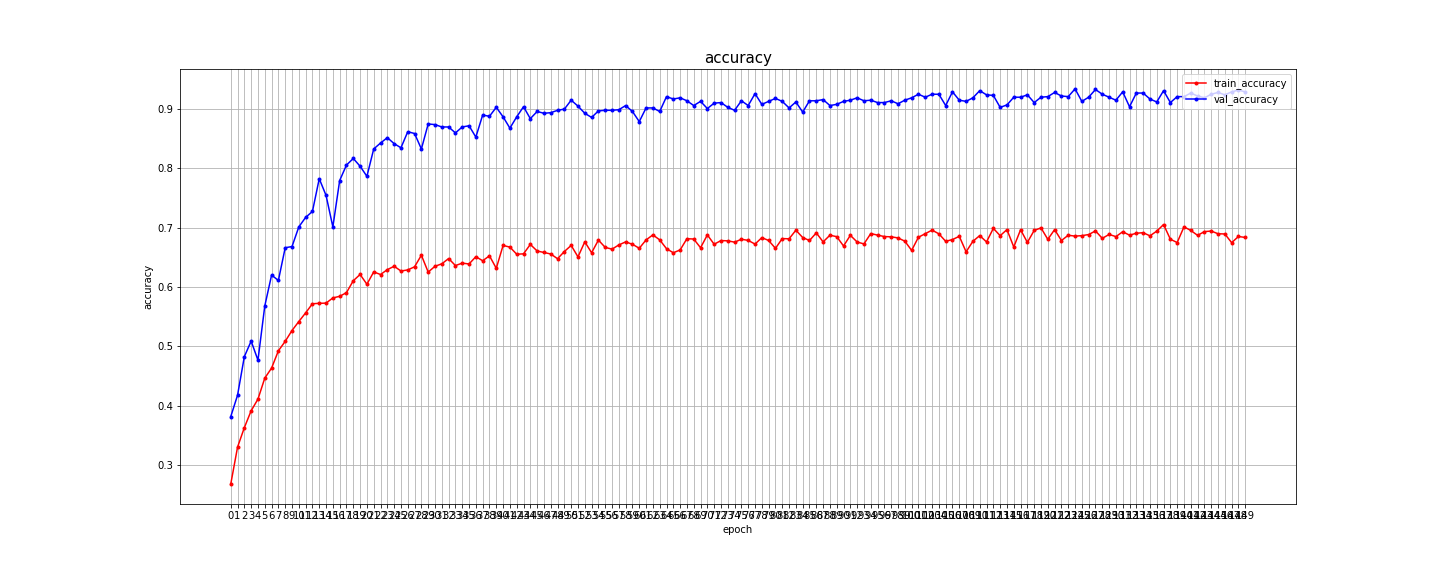

In [81]:
acc_plot_path = os.path.join(RECORDER_DIR, 'plots/accuracy.png')
Image.open(acc_plot_path)

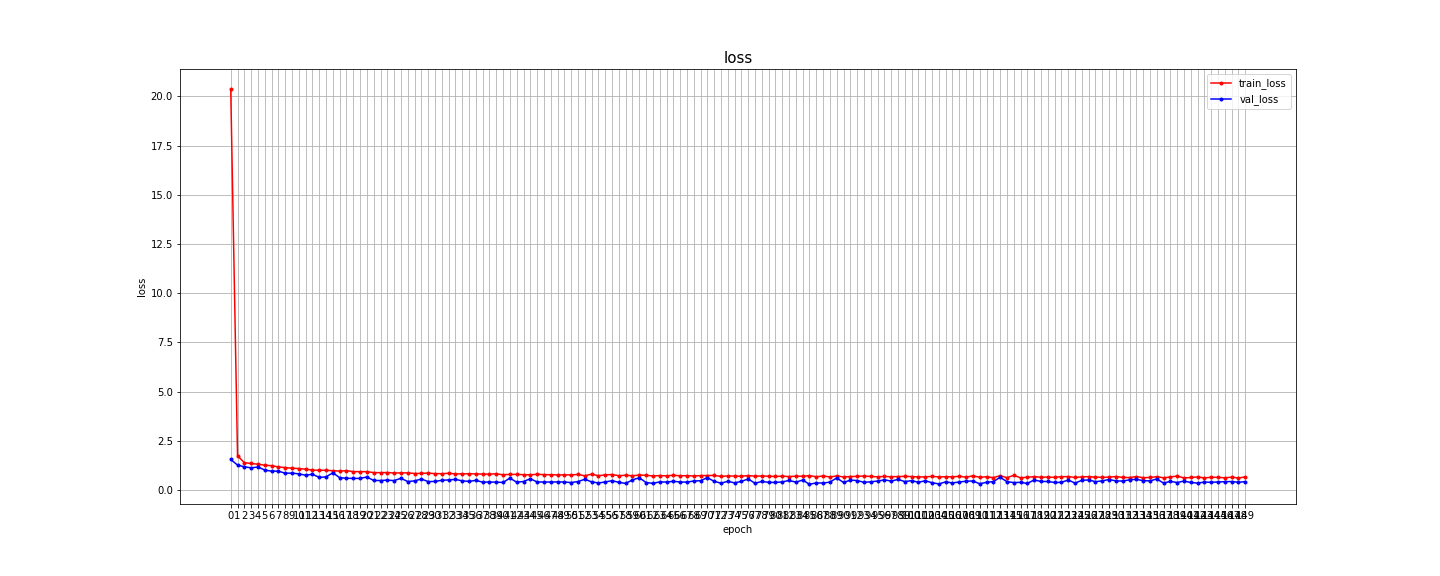

In [82]:
loss_plot_path = os.path.join(RECORDER_DIR, 'plots/loss.png')
Image.open(loss_plot_path)

## Predict

In [84]:
# Predict directory
PREDICT_DIR = os.path.join(PROJECT_DIR, 'results', 'predict', train_serial)
os.makedirs(PREDICT_DIR, exist_ok=True)

DATA_DIR = './data/images/test'
SAMPLE_DIR = './sample_submission.csv' 

# Load data
test_dataset = TestDataset(img_folder=os.path.join(DATA_DIR, 'images'),
                            dfpath=os.path.join(DATA_DIR, 'test_images.csv'))
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            num_workers=num_workers, 
                            shuffle=False,
                            pin_memory=pin_memory,
                            drop_last=drop_last)

# Load model 
pt_path = os.path.join(RECORDER_DIR, 'model.pt')
checkpoint = torch.load(pt_path)
model.load_state_dict(checkpoint['model'])

model.eval()

# Make predictions
y_preds = []
filenames = []

for batch_index, (x1, x2, filename) in enumerate(tqdm(test_dataloader)):
    x1, x2 = x1.to(device, dtype=torch.float), x2.to(device, dtype=torch.float)
    y_logits = model(x1, x2).cpu()
    y_pred = torch.argmax(y_logits, dim=1)
    y_logits = y_logits.detach().numpy()
    y_pred = y_pred.detach().numpy()
    for fname in filename:
        filenames.append(fname)
    for yp in y_pred:
        y_preds.append(yp)

# Decode Prediction Labels
label_decoding = {0:'1++', 1:'1+', 2:'1', 3:'2', 4:'3'}
pred_df = pd.DataFrame(list(zip(filenames, y_preds)), columns=['id','grade'])
pred_df['grade'] = pred_df['grade'].replace(label_decoding)

# Reorder 
sample_df = pd.read_csv(SAMPLE_DIR)
sorter = list(sample_df['id'])
resdf = pred_df.set_index('id')
result = resdf.loc[sorter].reset_index()

# Save predictions
resultpath = os.path.join(PREDICT_DIR, 'predictions.csv')
result.to_csv(resultpath, index=False)
print('Done')

100%|██████████| 271/271 [00:28<00:00,  9.48it/s]

Done


In [85]:
resultpath

'./model/results/predict/20220620_173431/predictions.csv'